This notebook runs inference to test set with the training fold models.

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.8),
    albumentations.GaussNoise(p=0.05),
    albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=20, always_apply=False, p=0.5),
    albumentations.RandomGamma(gamma_limit=(80, 200), always_apply=True, p=1),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

In [4]:
def loadDfForFold(fold_index = 0):
    #assert ((fold_index >= 0) and (fold_index <= 3)), "fold index must be between 0 and 3"
    df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df['is_valid'] = False
    df_test = pd.read_csv('data/training/test.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df_test['is_valid'] = True
    return pd.concat([df,df_test])

In [5]:
df = loadDfForFold(0)
sz = 256
BATCH_SIZE = 28
NUM_WORKERS = 16

In [6]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [-1+2*self.img1.data,-1+2*self.img2.data]
        return self
    
    def to_one(self): 
        return Image(0.5+torch.cat(self.data,2)/2)
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`. 
        `kwargs` are passed to the show method."""
        figsize = fai.ifnone(figsize, (6,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], y=y, **kwargs)
            x.show(ax=axs[i,1], y=z, **kwargs)
    
    def __repr__(self):
        return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'

In [7]:
class ImageTupleList(ImageList):
    def __init__(self, items, df_copy=None, validation_colname="", data_dir='',data_suffix=[],last_fn='', **kwargs):
        super().__init__(items, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix = df_copy,validation_colname,data_dir,data_suffix
        self.last_fn = last_fn
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('last_fn')
    
    def get(self, i):
        # keep random state to apply the same augmentations for both images
        random_state = random.getstate()
        img1 = super().get(i)
        random.setstate(random_state)
        img2 = self.open(self.last_fn)
        return ImageTuple(img1, img2)
    
    def open(self, fn)->Image:
        self.last_fn = fn.replace(self.data_suffix[0], self.data_suffix[1])
        img = cv2.imread(fn)
        # Apply transformations
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix[0],'').replace(self.data_suffix[1],''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix=[], **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or []
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add('', res.items.astype(str)), '_0.png')
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [8]:
multiLevelList = (ImageTupleList.from_df_custom(path='data/norm_patches/',
                                            df=df,
                                            suffix=['_0.png','_2.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_from_df('is_valid')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

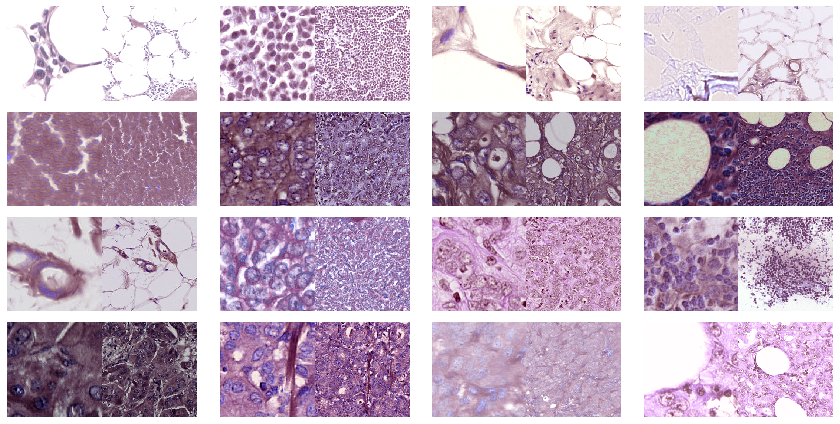

In [9]:
multiLevelList.show_batch(rows=4,ds_type=DatasetType.Train)

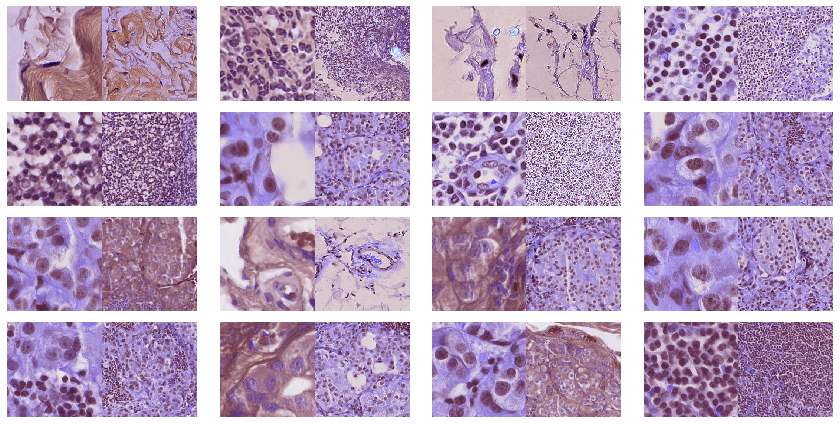

In [10]:
multiLevelList.show_batch(rows=4,ds_type=DatasetType.Valid)

## Model

In [11]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [12]:
# we wrap cadene model to pytorch models format
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [13]:
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

### Pretrained context encoder

In [14]:
encoder = se_resnext50_32x4d(pretrained=True).cuda()
# drop   (5): AvgPool2d(kernel_size=7, stride=1, padding=0)
#        (6): Linear(in_features=2048, out_features=1000, bias=True)
encoder = encoder[:5]

In [15]:
code_sz = 64

conv = nn.Conv2d(2048, code_sz, kernel_size=(2,2)).cuda()

encoder.add_module('CodeIn',conv)

In [16]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

In [17]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

In [18]:
add_layer(encoder,code_sz,512,'CodeOut',out_shape=(16,16),scale=None)
add_layer(encoder,512,256,'Upsample0')
add_layer(encoder,256,128,'Upsample1')
add_layer(encoder,128,64,'Upsample2')
add_layer(encoder,64,3,'Upsample3',act='sig')

In [19]:
df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
data_folder = './data/norm_patches/'
paths = [data_folder + str(patch) + '_2.png' for patch in df.patchId]
df['path'] = paths
df = df.set_index('path',drop=False)
df = df.drop(columns=['patchId','fileName','center','node','centerX','centerY',
                      'isTumor','tumorPercentage','tissuePercentage','meanHue',
                     'patient','meanSaturation','meanValue','tumorLabel'])

In [20]:
db = (ImageImageList.from_df(df=df,path='.')
      .split_by_rand_pct(0.2)
      .label_from_df('path')
      .transform(tfms=[[],[]], size=sz)
      .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
      .normalize(imagenet_stats))
learner_encoder = Learner(db,encoder,loss_func=F.mse_loss)
learner_encoder.split(lambda m: (m[4],m[5]))
learner_encoder.load('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned4')

/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UpSample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (107768 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Valid: LabelList (26942 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128

In [21]:
context_encoder_pretrained = learner_encoder.model[:5]
context_encoder_pretrained

Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): 

In [22]:
class MultiLevelModel(nn.Module):
    def __init__(self):
        super().__init__()
        # focus encoder outputs more features that are also more relevant to the label
        self.focus_encoder = nn.Sequential(create_body(se_resnext101_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
                                          
        # context encoder is a lighter CNN that outputs less features from the surrounding area
        #self.context_encoder = nn.Sequential(create_body(se_resnext50_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
        self.context_encoder = nn.Sequential(context_encoder_pretrained, nn.AdaptiveAvgPool2d(1))
    
        # head comes after concatenating the encoder outputs
        head_inp_sz = num_features_model(self.context_encoder) + num_features_model(self.focus_encoder)

        self.head = create_head(nf=head_inp_sz, nc=2 , ps=0.9, lin_ftrs=[2048,512])[2:]

    def forward(self, x1, x2):
        forward_1 = torch.cat(
            (
                self.focus_encoder(x1),
                self.context_encoder(x2)
            ),
            1
        )
        forward_1 = torch.reshape(forward_1,(forward_1.shape[0], -1))
        forward_2 = self.head(forward_1)
        return forward_2

In [23]:
loss_func = nn.CrossEntropyLoss()
learner = Learner(multiLevelList, MultiLevelModel(),loss_func=loss_func, metrics=[accuracy])

In [24]:
learner.model = nn.DataParallel(learner.model)

## Inference

In [25]:
def getDataBunch(fold_index = 0):
    df = loadDfForFold(fold_index)
    return (ImageTupleList.from_df_custom(path='data/norm_patches/',
                                            df=df,
                                            suffix=['_0.png','_2.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_from_df('is_valid')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

In [32]:
def getLearner(multiLevelList, modelPath = None):
    loss_func = nn.CrossEntropyLoss()
    learner = Learner(multiLevelList, 
                      MultiLevelModel(),
                      loss_func=loss_func, 
                      metrics=[accuracy], 
                      callback_fns=ShowGraph)
    if modelPath is not None:
        learner.load(modelPath)
    return learner

In [33]:
from sklearn.metrics import roc_curve, auc
model_name = '20190806-15-pretrained_normalized_multilevel5'

# saved for validation
interp_list = []
preds_list = []
y_list = []
loss_list = []
acc_list = []
tpr_list = []
fpr_list = []
roc_auc_list = []

for fold in [0,1,2,3]:
    print("##########################")
    print("Start inference CV fold " + str(fold))
    print("##########################")
    
        
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=fold)
    
    modelPath = model_name + '_fold' + str(fold) + '_stage-1'
    
    # init new learner
    learner = getLearner(fold_databunch, modelPath)
    
    # get preds for validation 
    preds,y, loss = learner.get_preds(with_loss=True)
    acc = accuracy(preds, y)
    acc_list.append(acc)
    print('The accuracy of the fold {1} model is {0} %.'.format(acc, fold))
    
    interp = ClassificationInterpretation.from_learner(learner)
    
    preds_list.append(preds)
    y_list.append(y)
    loss_list.append(loss)
    interp_list.append(interp)
    
    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area of the fold {1} is {0}'.format(roc_auc, fold))
    
    roc_auc_list.append(roc_auc)

ROC area of the fold 3 is 0.9587408284997537


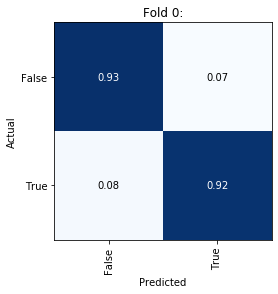

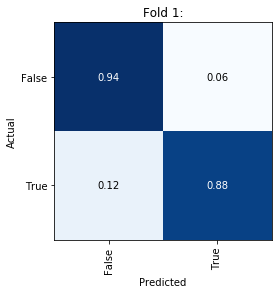

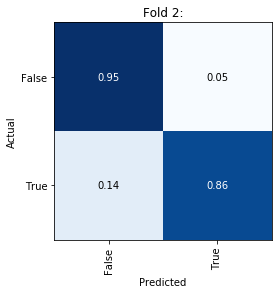

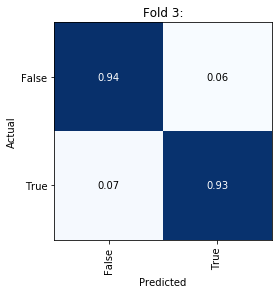

In [34]:
for i, interp in enumerate(interp_list):
    interp.plot_confusion_matrix(normalize=True, title="Fold {0}:".format(i))

In [35]:
for fold , acc in enumerate(acc_list):
    print('The accuracy of the fold {1} model is {0} %.'.format(acc*100, fold))

The accuracy of the fold 0 model is 92.6627426147461 %.
The accuracy of the fold 1 model is 92.6627426147461 %.
The accuracy of the fold 2 model is 91.35641479492188 %.
The accuracy of the fold 3 model is 91.35641479492188 %.
The accuracy of the fold 4 model is 90.52906799316406 %.
The accuracy of the fold 5 model is 90.52906799316406 %.
The accuracy of the fold 6 model is 93.77313232421875 %.
The accuracy of the fold 7 model is 93.77313232421875 %.


In [36]:
for fold , auc in enumerate(roc_auc_list):
    print('The AUC of the fold {1} model is {0} %.'.format(auc*100, fold))
print('The average AUC of all folds is {0} %'.format(np.asarray(roc_auc_list).mean()*100))
print('The std (ddof=1) of AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).std(ddof=1)*100))

The AUC of the fold 0 model is 96.23169450724176 %.
The AUC of the fold 1 model is 95.17246897689661 %.
The AUC of the fold 2 model is 94.386389819057 %.
The AUC of the fold 3 model is 95.87408284997537 %.
The average AUC of all folds is 95.41615903829268 %
The std (ddof=1) of AUC of all tests is 0.8153939353319716 %
